This script implements a YouTube video classification pipeline using LSTM neural networks.
The model classifies videos into 6 categories based on their titles and descriptions.

The pipeline includes:
- Data loading and preprocessing using both classical NLP and Keras approaches
- Text vectorization using Keras Tokenizer
- LSTM model architecture for sequence classification
- Model training with callbacks and visualization
- Model evaluation and persistence

`Author: Pouryare`

`Date: October 2024`

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  with open('/content/drive/MyDrive/ML/Videos Classification/' + fn, 'wb') as f:
    f.write(uploaded[fn])

Saving Videos_data.csv to Videos_data.csv
User uploaded file "Videos_data.csv" with length 2372618 bytes


In [2]:
# Importing libraries
from typing import Tuple, List, Dict, Any, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def load_data(filepath: str) -> pd.DataFrame:
    """
    Load and preprocess the video classification dataset.

    Args:
        filepath: Path to the CSV file containing video data

    Returns:
        Preprocessed DataFrame with video information
    """
    # Read data
    data = pd.read_csv(filepath)
    print("\nInitial data shape:", data.shape)
    print("\nSample of raw data:")
    print(data.head())

    # Drop unnamed column and handle missing values
    data = data.drop('Unnamed: 0', axis=1)
    print("\nMissing values before cleaning:")
    print(data.isnull().sum())

    # Drop rows with missing values
    data = data.dropna()
    print("\nShape after cleaning:", data.shape)

    return data

In [4]:
def prepare_text_data(
    data: pd.DataFrame,
    max_words: int = 10000,
    max_len: int = 50
) -> Tuple[np.ndarray, np.ndarray, Tokenizer, LabelEncoder]:
    """
    Prepare text data for deep learning model using Keras Tokenizer.

    Args:
        data: Input DataFrame with Title and Description columns
        max_words: Maximum number of words to keep
        max_len: Maximum length of sequences

    Returns:
        Processed sequences and labels along with fitted tokenizer and encoder
    """
    # Combine title and description
    print("\nCombining title and description...")
    titles = data['Title'].values
    descriptions = data['Description'].values
    combined_texts = []
    for i in range(len(titles)):
        combined_texts.append(f"{titles[i]} {descriptions[i]}")

    # Initialize and fit tokenizer
    print("\nTokenizing text...")
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(combined_texts)

    # Convert text to sequences
    sequences = tokenizer.texts_to_sequences(combined_texts)
    X = pad_sequences(sequences, maxlen=max_len)

    print("\nSample of processed sequences:")
    print(X[:5])

    # Encode labels
    print("\nEncoding labels...")
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['Category'])
    y = tf.keras.utils.to_categorical(y)

    print("\nUnique categories:", label_encoder.classes_)
    print("Sample of encoded labels:", y[:5])

    return X, y, tokenizer, label_encoder

In [5]:
def create_model(
    max_words: int,
    max_len: int,
    embedding_dim: int = 100,
    n_classes: int = 6
) -> Sequential:
    """
    Create LSTM model for text classification.

    Args:
        max_words: Vocabulary size
        max_len: Maximum sequence length
        embedding_dim: Dimension of embeddings
        n_classes: Number of output classes

    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    print("\nModel Summary:")
    model.summary()

    return model

In [6]:
def train_model(
    model: Sequential,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    epochs: int = 10,
    batch_size: int = 128
) -> tf.keras.callbacks.History:
    """
    Train the model with callbacks and return training history.

    Args:
        model: Keras Sequential model
        X_train, y_train: Training data
        X_val, y_val: Validation data
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        Training history
    """
    # Define callbacks
    checkpoint = ModelCheckpoint(
        'best_model.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stopping]
    )

    return history

In [7]:
def plot_training_history(history: tf.keras.callbacks.History) -> None:
    """
    Plot training history metrics.

    Args:
        history: Training history from model.fit()
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def evaluate_model(
    model: Sequential,
    X_test: np.ndarray,
    y_test: np.ndarray,
    label_encoder: LabelEncoder
) -> None:
    """
    Evaluate model performance on test set.

    Args:
        model: Trained Keras model
        X_test, y_test: Test data
        label_encoder: Fitted LabelEncoder
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Print classification report
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(
        y_test_classes,
        y_pred_classes,
        target_names=label_encoder.classes_
    ))

In [9]:
# Load and prepare data
print("Loading data...")
data = load_data('/content/drive/MyDrive/ML/Videos Classification/Videos_data.csv')

Loading data...

Initial data shape: (10333, 5)

Sample of raw data:
   Unnamed: 0     Video Id                                              Title  \
0           0  ehmsJLZlCZ0  Ep 1| Travelling through North East India | Of...   
1           1  e2NQE41J5eM    How do I travel so much ! How do I earn money!!   
2           2  i9E_Blai8vk      TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE   
3           3       #NAME?  GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...   
4           4  7ByoBJYXU0k               5 Steps to Becoming a Travel Blogger   

                                         Description Category  
0  The journey to Arunachal, North East India beg...   travel  
1  SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...   travel  
2  I had the chance to fly out to Bali with my wh...   travel  
3  Hope you enjoy MY GOA TRAVEL DIARY this video!...   travel  
4  Travel blogger, Nikki Vargas, of The Pin the M...   travel  

Missing values before cleaning:
Video Id         0
Title   

In [10]:
# Prepare text data
MAX_WORDS = 10000
MAX_LEN = 50
X, y, tokenizer, label_encoder = prepare_text_data(data, MAX_WORDS, MAX_LEN)


Combining title and description...

Tokenizing text...

Sample of processed sequences:
[[   0    0    0    0    0    0    0    0    0    0  497   54   27  191
   608  631  145  200    3 6352    1  523 1069 6353    1  523    3 6352
   608  631  145 1069   15    5  916  523   23 5473    3   23   53   30
   649    3 6353    4   82    4   29   26]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   18   84   20   26   93  260   18
    84   20 2458  539   50   17  107  109   17  107  109  100   11   70
   373  233 8095  917  125    3 1335   19]
 [   0    0    0    0    0    0    0    0    0    0    0    0   26  164
   264    3  809 2763   20  359    1 1336    3 2208   56    3  809   15
    29  698  369    9 4717    7   44   80  215  173 1298   20 1004    3
  3815   29 2459   93   32   20   59  675]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  2963   26 2327 1036  342    6 2963   26 8096  198  371   11  

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [12]:
# Create and train model
model = create_model(MAX_WORDS, MAX_LEN)
history = train_model(model, X_train, y_train, X_val, y_val)


Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.2919 - loss: 1.7357 - val_accuracy: 0.7444 - val_loss: 0.9496
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.7419 - loss: 0.7565 - val_accuracy: 0.9200 - val_loss: 0.2704
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.9352 - loss: 0.2353 - val_accuracy: 0.9700 - val_loss: 0.1393
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.9783 - loss: 0.1052 - val_accuracy: 0.9638 - val_loss: 0.1744
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9776 - loss: 0.1075 - val_accuracy: 0.9750 - val_loss: 0.1277
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.9897 - loss: 0.0580 - val_accuracy: 0.9731 - val_loss: 0.1413
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.9861 - loss: 0.0633 - val_accuracy: 0.9712 - val_loss: 0.1436
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9887 - loss: 0.0611 - val_accurac

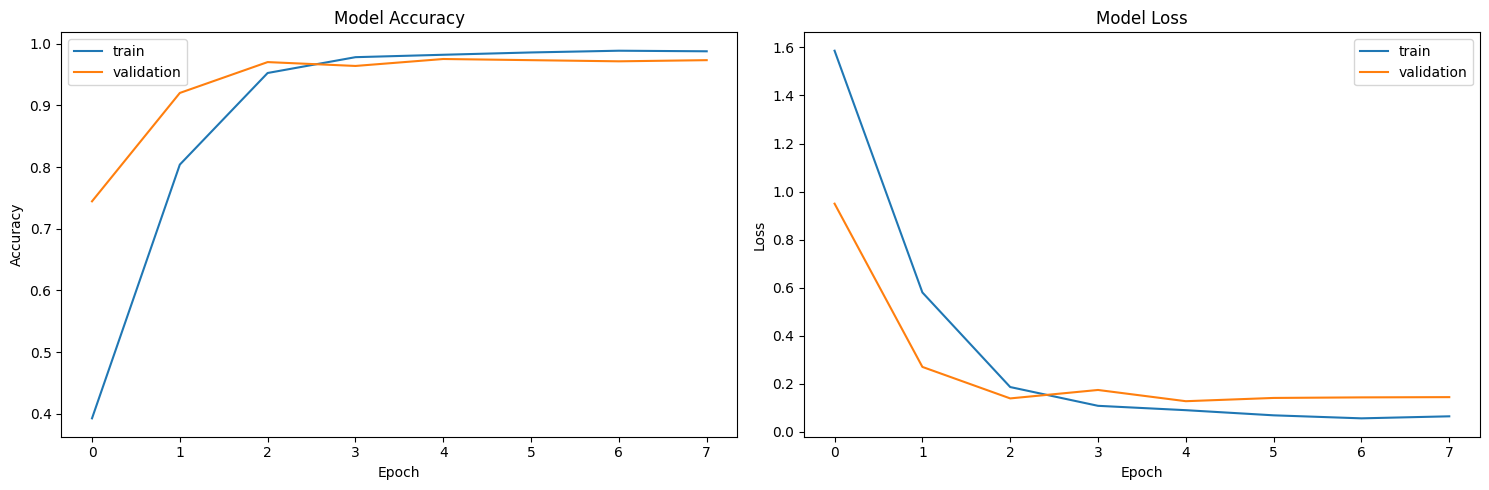

In [13]:
# Plot training history
plot_training_history(history)

In [14]:
# Load best weights and evaluate
model.load_weights('best_model.weights.h5')
evaluate_model(model, X_test, y_test, label_encoder)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

Classification Report:
                        precision    recall  f1-score   support

         art and music       0.98      0.99      0.98       335
                  food       0.98      0.97      0.98       339
               history       0.97      0.98      0.98       326
         manufacturing       0.99      0.99      0.99       335
science and technology       0.97      0.96      0.97       331
                travel       1.00      0.99      1.00       334

              accuracy                           0.98      2000
             macro avg       0.98      0.98      0.98      2000
          weighted avg       0.98      0.98      0.98      2000



In [15]:
# Save artifacts
print("\nSaving model artifacts...")
model.save('/content/drive/MyDrive/ML/Videos Classification/video_classification_model.keras')
joblib.dump(tokenizer, '/content/drive/MyDrive/ML/Videos Classification/tokenizer.joblib')
joblib.dump(label_encoder, '/content/drive/MyDrive/ML/Videos Classification/label_encoder.joblib')


Saving model artifacts...


['/content/drive/MyDrive/ML/Advertisement Classification/label_encoder.joblib']

In [16]:
# Example of using the saved model
print("\nExample of model usage:")
text = "How to make delicious pasta - Italian cooking tutorial"
sequence = tokenizer.texts_to_sequences([text])
padded = pad_sequences(sequence, maxlen=MAX_LEN)
prediction = model.predict(padded)
predicted_class = label_encoder.inverse_transform([np.argmax(prediction[0])])
print(f"Input text: {text}")
print(f"Predicted category: {predicted_class[0]}")


Example of model usage:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Input text: How to make delicious pasta - Italian cooking tutorial
Predicted category: food
